In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.current_device()

0

In [6]:
torch.set_default_device('cpu')

In [7]:
import pandas as pd
import numpy as np

In [8]:
data_5 = pd.read_csv('../../data/data5.csv')
data_6 = pd.read_csv('../../data/data8.csv')
data_5

seq  occurrence  0  1  2  3  4  5  6  7  ... 30 31 32 33 34 35  \
0            seq0           2  A  G  G  G  T  T  G  G  ...  G  G  G  G  G  G   
1            seq1           2  G  G  G  G  T  T  G  G  ...  G  T  A  A  G  C   
2            seq2           2  A  G  C  A  G  C  C  A  ...  T  G  A  G  G  T   
3            seq3           2  G  A  T  G  G  T  T  G  ...  T  T  A  C  G  T   
4            seq4           2  G  G  T  G  G  G  T  G  ...  C  A  G  C  G  A   
...           ...         ... .. .. .. .. .. .. .. ..  ... .. .. .. .. .. ..   
891909  seq891909           1  C  G  G  G  T  T  G  G  ...  A  T  C  G  G  T   
891910  seq891910           1  T  G  G  G  G  G  T  G  ...  C  C  T  T  A  C   
891911  seq891911           1  G  C  G  G  A  G  G  G  ...  G  G  G  T  G  G   
891912  seq891912           1  T  T  G  G  C  C  A  A  ...  A  A  T  G  C  C   
891913  seq891913           1  T  G  C  A  C  C  A  A  ...  C  G  G  G  T  G   

       36 37 38 39  
0       C  G  G  A  
1       A  A  A  C  
2       T  G  G  G  
3       G  T  A  C  
4       C  A  C  C  
...    .. .. .. ..  
891909  T  G  G  G  
891910  T  G  G  C  
891911  G  C  G  G  
891912  T  G  G  G  
891913  G  G  C  A  

[891914 rows x 42 columns]

In [9]:
joined = data_5.merge(data_6, on=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39'], how='outer', indicator=True)

In [10]:
joined.drop(["seq_x", 'seq_y', "occurrence_x"], axis=1, inplace=True)

In [11]:
joined.loc[np.isnan(joined["occurrence_y"]), "occurrence_y"] = 0
joined.occurrence_y.astype(int)

0          0
1          0
2          0
3          0
4          0
          ..
1611227    0
1611228    0
1611229    1
1611230    0
1611231    0
Name: occurrence_y, Length: 1611232, dtype: int64

In [12]:
joined.occurrence_y.unique()

array([ 0.,  1.,  2.,  4.,  3.,  5.,  9.,  8.,  6.,  7., 10., 17., 27.,
       12., 25., 13., 20., 11., 16., 14., 19., 29., 23., 21., 15.])

In [13]:
joined['occurrence_y'] = np.where(joined['occurrence_y'] > 0, 1, 0)

In [14]:
print(joined['occurrence_y'].unique())
print(len(joined))

[0 1]
1611232


In [15]:
# https://sparkbyexamples.com/pandas/how-to-count-duplicates-in-pandas-dataframe/
joined.pivot_table(index = ['occurrence_y'], aggfunc ='size')

occurrence_y
0    891819
1    719413
dtype: int64

In [16]:
joined_matrix = [[[0] * 40 for i in range(4)] for n in range(len(joined))]
print(np.array(joined_matrix).shape)

(1611232, 4, 40)


In [17]:
joined.reset_index(inplace=True)

for index, row in joined.iterrows():
    x = 0
    for i in row:
        if (i == 'A'):
            joined_matrix[index][0][x] = 1
        elif (i == 'C'):
            joined_matrix[index][1][x] = 1
        elif (i == 'G'):
            joined_matrix[index][2][x] = 1
        elif (i == 'T'):
            joined_matrix[index][3][x] = 1
        else:
            continue
        x += 1

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(joined_matrix, joined.occurrence_y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) 

In [19]:
import torch
import torch.utils.data as data_utils
train_y = torch.tensor(y_train.values.astype(np.longlong))
train_x = torch.tensor(np.array(x_train).astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train_x, train_y) 
trainloader = data_utils.DataLoader(dataset = train_tensor, batch_size = 128)

val_y = torch.tensor(y_val.values.astype(np.longlong))
val_x = torch.tensor(np.array(x_val).astype(np.float32)) 
val_tensor = data_utils.TensorDataset(val_x, val_y) 
valloader = data_utils.DataLoader(dataset = val_tensor, batch_size = 128)

test_y = torch.tensor(y_test.values.astype(np.longlong))
test_x = torch.tensor(np.array(x_test).astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test_x, test_y) 
testloader = data_utils.DataLoader(dataset = test_tensor, batch_size = 128)

In [20]:
from torch import nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels = 4, out_channels = 64, kernel_size = 5)
        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 3)
        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.conv3 = nn.Conv1d(in_channels = 256, out_channels = 32, kernel_size = 3)
        self.pool3 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.conv3_drop = nn.Dropout1d(p=0.2)
    
        self.fco = nn.Linear(in_features=3, out_features=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.conv3_drop(x)
        
        x = self.fco(x)
        x = x.flatten(start_dim = 1)
        return x

In [21]:
model = MLP()
input_data = np.array([])
for oneBatch in trainloader:
    inputs, res = oneBatch
    outputs = model(inputs)
    break

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()

loss = loss_fn(outputs, res)
print('Total loss for this batch: {}'.format(loss.item()))

Total loss for this batch: 4.173467636108398


In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
from tqdm import tqdm

def train_one_epoch(model, loss_fn, optimizer, trainloader):
    running_cum_loss = 0.

    for data in tqdm(trainloader):
        inputs, labels = data
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    return running_cum_loss / len(x_train)

loss = train_one_epoch(model, loss_fn, optimizer, trainloader)
print(f"Celková trénovací chyba: {loss}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:59<00:00, 126.26it/s]

Celková trénovací chyba: 1.2891002209210738


In [25]:
#https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376

import copy

best_loss = float('inf')
best_model_weights = None
patience = 10
EPOCHS = 100

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    avg_loss = train_one_epoch(model, loss_fn, optimizer, trainloader)

    running_cum_vloss = 0.0
    vcorrect = 0
    for i, vdata in enumerate(valloader):
        vinputs, vlabels = vdata
        with torch.no_grad():
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
        running_cum_vloss += vloss * vinputs.shape[0]
        vcorrect += (voutputs.argmax(1) == vlabels).float().sum()

    avg_vloss = running_cum_vloss / len(x_val)
    vacc = vcorrect / len(x_val)
    
    print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.5f}, accuraccy: {vacc:.5f}")
    
    if avg_vloss < best_loss:
        best_loss = avg_vloss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            break

EPOCH 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:00<00:00, 123.99it/s]


TRAIN loss: 1.174, VALIDATION loss: 1.15243, accuraccy: 0.77165
EPOCH 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:59<00:00, 126.78it/s]


TRAIN loss: 1.145, VALIDATION loss: 1.13209, accuraccy: 0.78384
EPOCH 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:00<00:00, 124.20it/s]


TRAIN loss: 1.130, VALIDATION loss: 1.12682, accuraccy: 0.78928
EPOCH 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:00<00:00, 125.74it/s]


TRAIN loss: 1.118, VALIDATION loss: 1.11348, accuraccy: 0.79397
EPOCH 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:00<00:00, 125.19it/s]


TRAIN loss: 1.116, VALIDATION loss: 1.11642, accuraccy: 0.79548
EPOCH 6:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:59<00:00, 126.32it/s]


TRAIN loss: 1.112, VALIDATION loss: 1.10686, accuraccy: 0.79913
EPOCH 7:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:59<00:00, 126.53it/s]


TRAIN loss: 1.106, VALIDATION loss: 1.10960, accuraccy: 0.79723
EPOCH 8:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:57<00:00, 131.06it/s]


TRAIN loss: 1.106, VALIDATION loss: 1.10630, accuraccy: 0.80048
EPOCH 9:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 134.91it/s]


TRAIN loss: 1.103, VALIDATION loss: 1.10374, accuraccy: 0.80164
EPOCH 10:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:56<00:00, 134.17it/s]


TRAIN loss: 1.104, VALIDATION loss: 1.10168, accuraccy: 0.80307
EPOCH 11:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:56<00:00, 134.73it/s]


TRAIN loss: 1.101, VALIDATION loss: 1.10386, accuraccy: 0.80293
EPOCH 12:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.89it/s]


TRAIN loss: 1.097, VALIDATION loss: 1.10424, accuraccy: 0.80292
EPOCH 13:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.99it/s]


TRAIN loss: 1.100, VALIDATION loss: 1.09678, accuraccy: 0.80404
EPOCH 14:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.71it/s]


TRAIN loss: 1.096, VALIDATION loss: 1.09950, accuraccy: 0.80455
EPOCH 15:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.02it/s]


TRAIN loss: 1.094, VALIDATION loss: 1.10247, accuraccy: 0.80410
EPOCH 16:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.08it/s]


TRAIN loss: 1.096, VALIDATION loss: 1.09742, accuraccy: 0.80461
EPOCH 17:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.55it/s]


TRAIN loss: 1.092, VALIDATION loss: 1.09758, accuraccy: 0.80458
EPOCH 18:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 136.01it/s]


TRAIN loss: 1.093, VALIDATION loss: 1.09471, accuraccy: 0.80586
EPOCH 19:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 136.91it/s]


TRAIN loss: 1.092, VALIDATION loss: 1.09363, accuraccy: 0.80608
EPOCH 20:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 136.13it/s]


TRAIN loss: 1.092, VALIDATION loss: 1.09761, accuraccy: 0.80516
EPOCH 21:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:55<00:00, 135.04it/s]


TRAIN loss: 1.091, VALIDATION loss: 1.09132, accuraccy: 0.80640
EPOCH 22:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:58<00:00, 129.61it/s]


TRAIN loss: 1.089, VALIDATION loss: 1.09347, accuraccy: 0.80586
EPOCH 23:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:02<00:00, 121.68it/s]


TRAIN loss: 1.089, VALIDATION loss: 1.09463, accuraccy: 0.80629
EPOCH 24:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:03<00:00, 119.83it/s]


TRAIN loss: 1.089, VALIDATION loss: 1.08935, accuraccy: 0.80501
EPOCH 25:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:58<00:00, 129.21it/s]


TRAIN loss: 1.089, VALIDATION loss: 1.09431, accuraccy: 0.80541
EPOCH 26:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:04<00:00, 117.59it/s]


TRAIN loss: 1.091, VALIDATION loss: 1.09628, accuraccy: 0.80550
EPOCH 27:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:04<00:00, 116.36it/s]


TRAIN loss: 1.088, VALIDATION loss: 1.08573, accuraccy: 0.80655
EPOCH 28:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:02<00:00, 120.41it/s]


TRAIN loss: 1.086, VALIDATION loss: 1.09215, accuraccy: 0.80616
EPOCH 29:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:03<00:00, 119.80it/s]


TRAIN loss: 1.087, VALIDATION loss: 1.09630, accuraccy: 0.80649
EPOCH 30:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:00<00:00, 124.90it/s]


TRAIN loss: 1.087, VALIDATION loss: 1.09272, accuraccy: 0.80672
EPOCH 31:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:01<00:00, 122.87it/s]


TRAIN loss: 1.086, VALIDATION loss: 1.09188, accuraccy: 0.80741
EPOCH 32:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:03<00:00, 119.57it/s]


TRAIN loss: 1.087, VALIDATION loss: 1.09378, accuraccy: 0.80690
EPOCH 33:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:58<00:00, 128.27it/s]


TRAIN loss: 1.085, VALIDATION loss: 1.08984, accuraccy: 0.80775
EPOCH 34:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [00:59<00:00, 126.25it/s]


TRAIN loss: 1.085, VALIDATION loss: 1.09140, accuraccy: 0.80710
EPOCH 35:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:02<00:00, 121.32it/s]


TRAIN loss: 1.084, VALIDATION loss: 1.08975, accuraccy: 0.80685
EPOCH 36:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:03<00:00, 118.68it/s]


TRAIN loss: 1.086, VALIDATION loss: 1.09022, accuraccy: 0.80687
EPOCH 37:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:01<00:00, 123.19it/s]


TRAIN loss: 1.085, VALIDATION loss: 1.09405, accuraccy: 0.80547


In [26]:
#https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [27]:
test_predictions = np.zeros(len(x_test))
test_y = np.zeros(len(x_test))
print(test_predictions.shape)
ii = 0
for vdata in testloader:
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = torch.Tensor.cpu(voutputs.argmax(1)).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = torch.Tensor.cpu(vlabels).numpy()
    ii += vinputs.shape[0]

(322247,)


In [28]:
from sklearn.metrics import accuracy_score
print(f"Testovací přesnost: {accuracy_score(test_y, test_predictions)}")

Testovací přesnost: 0.8046001979847757


In [29]:
PATH = 'm1-u-2.pt'
torch.save(model.state_dict(), PATH)

In [31]:
data = pd.read_csv('../../data/new_test_data.csv')

In [32]:
matrix = [[[0] * 40 for i in range(4)] for n in range(len(data))]
print(np.array(matrix).shape)

(793, 4, 40)


In [33]:
data.reset_index(inplace=True)

for index, row in data.iterrows():
    x = 0
    for i in row:
        if (i == 'A'):
            matrix[index][0][x] = 1
        elif (i == 'C'):
            matrix[index][1][x] = 1
        elif (i == 'G'):
            matrix[index][2][x] = 1
        elif (i == 'T'):
            matrix[index][3][x] = 1
        else:
            continue
        x += 1

In [34]:
import torch
import torch.utils.data as data_utils
test_y = torch.tensor(data.occurrence.values.astype(np.longlong))
test_x = torch.tensor(np.array(matrix).astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test_x, test_y) 
testloader = data_utils.DataLoader(dataset = test_tensor, batch_size = 128)

In [36]:
test_predictions = np.zeros(len(data.occurrence))
test_y = np.zeros(len(matrix))
print(test_predictions.shape)
ii = 0
for vdata in testloader:
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = voutputs.argmax(1).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = vlabels.numpy()
    ii += vinputs.shape[0]

(793,)


In [37]:
from sklearn.metrics import accuracy_score
print(f"Testovací přesnost: {accuracy_score(test_y, test_predictions)}")

Testovací přesnost: 0.6557377049180327


In [39]:
from sklearn import metrics
metrics.f1_score(1-test_y, 1-test_predictions)

0.08080808080808081

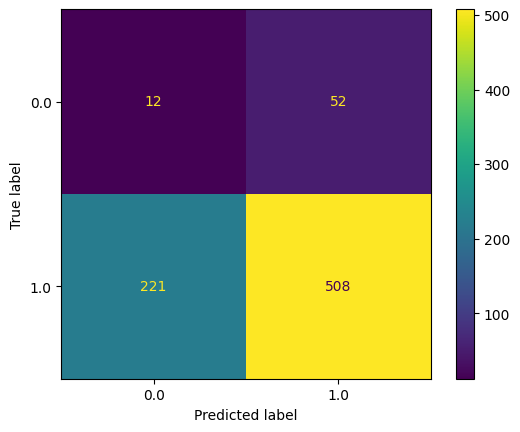

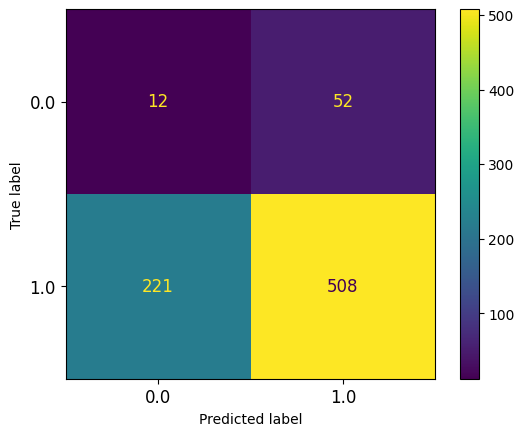

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already imported necessary modules and defined data and prediction

# Generate the confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(test_y, test_predictions)

fig, ax = plt.subplots()

disp.plot(ax=ax)

# Increase font size of values inside the matrix
for i in range(len(disp.text_)):
    for j in range(len(disp.text_[0])):
        disp.text_[i][j].set_fontsize(12)

# Set font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()